<h1>Options Analysis and Stock Trading Model</h1>
-------------------------------------------------------------------------------------------------------------------
<h3>A combination of an LSTM model trained on historical time series data and a model from
transformers for NLP Sentiment Analysis on stock news.</h3>
<p>This Jupyter Notebook also includes an in-depth analysis of traditional <strong>stock options</strong> to see the relations between different features and assess the performance of the models outlined.</p>

<h4>1. LSTM Model</h4>
<h5>1a. Collecting Data</h5> 

Data is collected from <strong>yfinance and google finance</strong> services, which offer comprehensive, real time information about stock/ticker statistics, news, and background information.

In [37]:
import yfinance as yf
import pandas as pd

In [38]:
#The tickers data is collected from https://www.nasdaq.com/market-activity/stocks/screener in csv form
data = pd.read_csv("nasdaq_screener_1722940907577.csv")
stock_tickers = list(data['Symbol'])
stock_tickers


['A',
 'AA',
 'AACG',
 'AACI',
 'AACIU',
 'AACIW',
 'AACT',
 'AADI',
 'AAGR',
 'AAGRW',
 'AAL',
 'AAMC',
 'AAME',
 'AAN',
 'AAOI',
 'AAON',
 'AAP',
 'AAPL',
 'AAT',
 'AB',
 'ABAT',
 'ABBV',
 'ABCB',
 'ABCL',
 'ABEO',
 'ABEV',
 'ABG',
 'ABIO',
 'ABL',
 'ABLLL',
 'ABLLW',
 'ABLV',
 'ABLVW',
 'ABM',
 'ABNB',
 'ABOS',
 'ABR',
 'ABR^D',
 'ABR^E',
 'ABR^F',
 'ABSI',
 'ABT',
 'ABTS',
 'ABUS',
 'ABVC',
 'ABVE',
 'ABVEW',
 'ABVX',
 'AC',
 'ACA',
 'ACAB',
 'ACABW',
 'ACAC',
 'ACACW',
 'ACAD',
 'ACB',
 'ACCD',
 'ACCO',
 'ACDC',
 'ACEL',
 'ACET',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACHC',
 'ACHL',
 'ACHR',
 'ACHV',
 'ACI',
 'ACIC',
 'ACIU',
 'ACIW',
 'ACLS',
 'ACLX',
 'ACM',
 'ACMR',
 'ACN',
 'ACNB',
 'ACNT',
 'ACON',
 'ACONW',
 'ACP',
 'ACP^A',
 'ACR',
 'ACR^C',
 'ACR^D',
 'ACRE',
 'ACRS',
 'ACRV',
 'ACST',
 'ACT',
 'ACTG',
 'ACU',
 'ACV',
 'ACVA',
 'ACXP',
 'ADAG',
 'ADAP',
 'ADBE',
 'ADC',
 'ADC^A',
 'ADCT',
 'ADD',
 'ADEA',
 'ADGM',
 'ADI',
 'ADIL',
 'ADM',
 'ADMA',
 'ADN',
 'ADNT',
 'ADNWW',
 'ADP

In [39]:
# Function to get historical data for stock tickers using yfinance
def get_stock_data(tickers, start_date='1900-01-01'):
    stock_data = {}
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date)
            stock_data[ticker] = data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return stock_data

Getting the historical data for each ticker and save as each as a .csv...

In [ ]:
stock_data = get_stock_data(stock_tickers)

for key in stock_data.keys():
    try:
        pd.DataFrame(stock_data[key]).to_csv(f'./historical-data/{key}-data.csv')
    except Exception as e:
        print(e)

In [43]:
data = pd.read_csv('historical-data/A-data.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,26.603022,62546380
1,1999-11-19,30.713518,30.758226,28.478184,28.880545,24.411299,15234146
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,26.603022,6577870
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.184568,5975611
4,1999-11-24,28.701717,29.998213,28.612303,29.372318,24.826967,4843231
...,...,...,...,...,...,...,...
6211,2024-07-30,138.039993,139.729996,137.110001,139.490005,139.490005,1428000
6212,2024-07-31,140.389999,144.000000,139.710007,141.399994,141.399994,2582700
6213,2024-08-01,142.240005,144.220001,141.750000,142.860001,142.860001,2896500
6214,2024-08-02,141.979996,143.169998,135.759995,139.039993,139.039993,2298400


<h5>1b. Analysis and Modeling Data with LSTM Model</h5>

Import libraries for data engineering and model training.

In [42]:
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Plot the data to visualize the historical data.

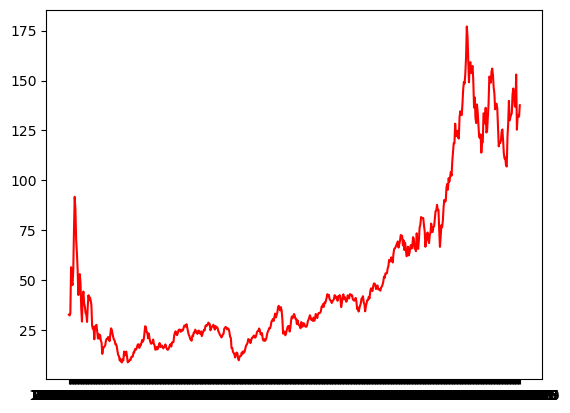

In [44]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(data["Date"][::10], data["Open"][::10], color='r')
plt.show()

Feature Engineering Process

1. Scale data using MinMaxScaler (dropping DATE column).
2. Create X, y Datasets such that each y value is offset one value forward in comparison to X.
3. Train/Test Split.
4. Reshape input dataset (train_X and test_X) to a 3-Dimensional Array (samples, timesteps, features).

In [45]:
#scaler for data
scaler = MinMaxScaler(feature_range=(0,1))
norm_data = scaler.fit_transform(data[data.columns.drop("Date")])

In [46]:
#function to create dataset with offset
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
            a = data.iloc[i].values
            dataX.append(a)
            dataY.append(data.iloc[i+look_back].values)
    return np.array(dataX), np.array(dataY)

Why is this necessary? All the previous values (now X) up until that point need to include be correlated with the next value (now y) based on how much the offset or lookback is. Thus, the previous values, X will now be used to train/predict the next value, y.

In [47]:
#Train/test split 3:1
train_size = int(len(norm_data) * 0.67)
train, test = pd.DataFrame(norm_data[:train_size]), pd.DataFrame(norm_data[train_size:])
train_X, train_y = create_dataset(train)
test_X, test_y = create_dataset(test)

In [48]:
#Reshape to 3D because LSTM model accepts a 3D array
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [49]:
#Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 6)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=2)


Epoch 1/100

4162/4162 - 7s - loss: 0.0015 - 7s/epoch - 2ms/step
Epoch 2/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 3/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 4/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 5/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 6/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 7/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 8/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 9/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 10/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 11/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 12/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 13/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 14/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 15/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 16/100
4162/4162 - 5s - lo

In [50]:
#Save the model
model.save("model-predictor-single-trained.h5")

c:\Users\alish\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h5>1c. Retrain Model with Multiple Historical Datasets</h5> 

We will now retrain the model with multiple historical datasets.

In [51]:
import glob

file_paths = glob.glob('historical-data/*.csv')
loaded_model = keras.models.load_model('model-predictor-single-trained.h5')

for file_path in file_paths[::100]:
    data = pd.read_csv(file_path)

    if len(data.index) == 0:
        continue

    norm_data = scaler.fit_transform(data[data.columns.drop("Date")])

    train_size = int(len(norm_data) * 0.67)
    train, test = pd.DataFrame(norm_data[:train_size]), pd.DataFrame(norm_data[train_size:])

    train_X, train_y = create_dataset(train)
    test_X, test_y = create_dataset(test)
    
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 2/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 3/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 4/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 5/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 6/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 7/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 8/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 9/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 10/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 11/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 12/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 13/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 14/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 15/100
4162/4162 - 5s - loss: 0.0013 - 5s/epoch - 1ms/step
Epoch 16/100
4162/4162 - 5s - loss

In [52]:
#Save the model
model.save('model-predictor-trained-multidatasets.h5')

c:\Users\alish\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h3>2. NLP Sentiment Analysis Model</h3>

Using the news provided by Google Finance, we will analyze the data using Natural Language Processing and Sentiment Analysis.

In [53]:
import requests
from serpapi import GoogleSearch
from bs4 import BeautifulSoup
import configparser
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

In [54]:
# Load API key from config file
config = configparser.ConfigParser()
config.read('D:\\coding-work\\stock-tracker-web-app\\codingtrackerapp\\myapp\\config.ini')

['D:\\coding-work\\stock-tracker-web-app\\codingtrackerapp\\myapp\\config.ini']

In [55]:
# Function to get news links from SERP API
def get_news_links(symbol):
    params = {
        "engine": "google_finance",
        "q": f"{symbol}:NASDAQ",
        "api_key": config['DEFAULT']['GOOGLE_FINANCE_API_KEY']
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    news_results = results['news_results']

    if 'link' in news_results[0]:
        return [result['link'] for result in news_results]
    else:
        news_items = news_results[0]['items']
        return [item['link'] for item in news_items]

In [56]:
# Function to extract text from news articles
def get_article_text(link):
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    p_tags = soup.find_all('p')
    return ' '.join(tag.get_text() for tag in p_tags).lower()

In [57]:
# Function to perform sentiment analysis using a pre-trained model
def perform_sentiment_analysis(texts):
    if not texts:
        return [0.5] * len(texts)  # Return neutral score if no text is found

    # Load pre-trained tokenizer and model
    model_name = "yiyanghkust/finbert-tone"  # Financial sentiment model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

    # Tokenize and process the text
    inputs = tokenizer(texts, return_tensors="tf", padding="max_length", truncation=True, max_length=512)
    
    # Perform sentiment analysis
    outputs = model(inputs).logits

    # Convert logits to probabilities (sigmoid for binary classification)
    probabilities = tf.nn.softmax(outputs, axis=1)

    # Get the positive class probability
    positive_scores = probabilities[:, 1].numpy()

    return positive_scores

In [58]:
#Example with 'GOOG' symbol
symbol = 'GOOG'

# Fetch news links
news_links = get_news_links(symbol)

if news_links:
    # Extract text from articles
    texts = [get_article_text(link) for link in news_links]

    # Perform sentiment analysis
    sentiments = perform_sentiment_analysis(texts)

    # Print results
    for text, sentiment in zip(texts, sentiments):
        print(f"Text: {text[:60]}... | Sentiment Score: {sentiment:.2f}")

c:\Users\alish\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Be

Text: founded in 1993, the motley fool is a financial services com... | Sentiment Score: 0.47
Text: like the temperature throughout august, the stock buying act... | Sentiment Score: 0.01
Text: google isn't just shipping ai products to customers as fast ... | Sentiment Score: 0.00
Text: google, a subsidiary of alphabet inc. goog googl, announced ... | Sentiment Score: 0.13
Text: share we go inside the waymo warehouse to see how the autono... | Sentiment Score: 0.35
Text:     kenneth cheung   kenneth cheung my last article about go... | Sentiment Score: 1.00
